In [33]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy.ma as ma
import seaborn as sns
import scipy.optimize
from matplotlib import cm
from numpy import unravel_index
from scipy.stats import ks_2samp

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

In [2]:
g = 9.8 # gravitational acceleration [m s-2]
rho_air = 1.395 # density of air (kg m-3)
rho_water = 1000 #density of water (kg m-3)
eps = 0.01802/0.02897 # ratio of MW_water to MW_air

In [3]:
# array of years
years = np.arange( 1983, 2008 )

# create list of file names
file_years = file_concatenator(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude")
maxlat_array = nc_open_compile(file_years,"max latitude")
pmax_array = nc_open_compile(file_years,"pmax")
cape_array = nc_open_compile(file_years,"cape")

tropical_indx = np.argwhere( (minlat_array >= -10) & (maxlat_array <= 10) & (cape_array > 10))[:,0]
tropical_rain_indx = np.argwhere( (minlat_array >= -10) & (maxlat_array <= 10) &
                                  (pmax_array >= np.percentile(pmax_array,75)) & (cape_array > 10) )[:,0]
print(tropical_indx.shape)
print(tropical_rain_indx.shape)

# applying same for MCS lifetime and morphology
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERAI = negative_to_nan(lifetime_array)[tropical_rain_indx]
rad_array = nc_open_compile(file_years,"rad")
rad_ERAI = negative_to_nan(rad_array)[tropical_rain_indx]
ctt_array = nc_open_compile(file_years,"ctt")
ctt_ERAI = negative_to_nan(ctt_array)[tropical_rain_indx]
rad_array = nc_open_compile(file_years,"rad")
rad_ERAI = negative_to_nan(rad_array)[tropical_rain_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERAI = negative_to_nan(minctt_array)[tropical_rain_indx]
cape_ERAI = negative_to_nan(cape_array)[tropical_rain_indx]

# Read in the vertical velocities
omega_array = nc_open_compile(file_years,"omega",'stack')[tropical_rain_indx]
# Extract the value around 550 hPa
omega_ERAI_mid = omega_array[:,14]
# Extract the value around 200 hPa
omega_ERAI_hi = omega_array[:,4]
# Filter for negative values of omega (ascent rates)
omega_ERAI_mid_n, cape_ERAI_n = negative_vals( omega_ERAI_mid, cape_ERAI )
omega_ERAI_hi_n, _ = negative_vals( omega_ERAI_hi, cape_ERAI )

(278407,)
(89404,)


In [4]:
def scatter_hist(x, y, xbins, ybins, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    h = ax.hist2d( x, y, bins=(xbins, ybins), cmap=cm.Blues )
    wgts = np.ones_like(x)/float(len(x))*100
    ax_histx.hist(x, bins=xbins, edgecolor='k', weights=wgts )
    ax_histx.tick_params(axis='both', which='major', labelsize=font_size-5)
    wgts = np.ones_like(y)/float(len(y))*100
    ax_histy.hist(y, bins=ybins, edgecolor='k', weights=wgts, orientation='horizontal')
    ax_histy.tick_params(axis='both', which='major', labelsize=font_size-5)
    #ax_histy.set_yscale('log')
    return h

In [60]:
_, rad_ERAI_n = negative_vals( omega_ERAI_mid, rad_ERAI )
_, minctt_ERAI_n = negative_vals( omega_ERAI_mid, minctt_ERAI )
_, lifetime_ERAI_n = negative_vals( omega_ERAI_mid, lifetime_ERAI )
_, ctt_ERAI_n = negative_vals( omega_ERAI_mid, ctt_ERAI )
ascent550_list = [ omega_ERAI_mid_n, omega_ERAI_mid_n[rad_ERAI_n <= np.percentile(rad_ERAI_n,25)],
                    omega_ERAI_mid_n[rad_ERAI_n >= np.percentile(rad_ERAI_n,75)],
                    omega_ERAI_mid_n[minctt_ERAI_n <= np.percentile(minctt_ERAI_n,25)],
                    omega_ERAI_mid_n[minctt_ERAI_n >= np.percentile(minctt_ERAI_n,75)],
                    omega_ERAI_mid_n[lifetime_ERAI_n <= np.percentile(lifetime_ERAI_n,25)],
                    omega_ERAI_mid_n[lifetime_ERAI_n >= np.percentile(lifetime_ERAI_n,75)] ]

In [54]:
# Are the histograms of omega_550^(-) statistically significantly different when stratifying for extent?
i = np.argwhere( ~np.isnan(ascent550_list[0]) )
data1 = ascent550_list[0][i[:,0]]

i = np.argwhere( ~np.isnan(ascent550_list[1]) )
data2 = ascent550_list[1][i[:,0]]

i = np.argwhere( ~np.isnan(ascent550_list[2]) )
data3 = ascent550_list[2][i[:,0]]

statistic, p_value = ks_2samp( data1, data2 )
print( statistic, p_value )

statistic, p_value = ks_2samp( data1, data3 )
print( statistic, p_value )

statistic, p_value = ks_2samp( data2, data3 )
print( statistic, p_value )

0.03681083231417992 1.5206014246599097e-15
0.043485294598329616 2.3689951386973287e-21
0.08013413767528427 2.3179759476529475e-45


In [62]:
# Are the histograms of omega_550^(-) statistically significantly different when stratifying for depth or lifetime?
i = np.argwhere( ~np.isnan(ascent550_list[0]) )
data1 = ascent550_list[0][i[:,0]]

i = np.argwhere( ~np.isnan(ascent550_list[3]) )
data2 = ascent550_list[3][i[:,0]]

i = np.argwhere( ~np.isnan(ascent550_list[4]) )
data3 = ascent550_list[4][i[:,0]]

i = np.argwhere( ~np.isnan(ascent550_list[5]) )
data4 = ascent550_list[5][i[:,0]]

i = np.argwhere( ~np.isnan(ascent550_list[6]) )
data5 = ascent550_list[6][i[:,0]]

statistic, p_value = ks_2samp( data1, data2 )
print( statistic, p_value )

statistic, p_value = ks_2samp( data1, data3 )
print( statistic, p_value )

statistic, p_value = ks_2samp( data2, data3 )
print( statistic, p_value )
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

statistic, p_value = ks_2samp( data1, data4 )
print( statistic, p_value )

statistic, p_value = ks_2samp( data1, data5 )
print( statistic, p_value )

statistic, p_value = ks_2samp( data4, data5 )
print( statistic, p_value )

0.03097201876657585 5.742297044084556e-11
0.014491726757706824 0.00531456815426912
0.044456329602517775 5.329247516855805e-15
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.016590872947820468 0.00017900336558748927
0.019529126856072332 0.00010275091822290384
0.0356138494492938 5.3785262752674866e-11


In [57]:
xbins1 = np.linspace( 0, 50, 40 )
ybins1 = np.logspace( -2, 1, 40 )

# Find the 25th percentile of lifetime to define 'short-lived' (3 hours)
i = np.where( lifetime_ERAI_n <= np.percentile( lifetime_ERAI_n, 15 ) )
omega_ERAI_young = omega_ERAI_mid_n[i]
cape_ERAI_young = cape_ERAI_n[i]
i = np.where( (~np.isnan(omega_ERAI_young)) & (~np.isnan(cape_ERAI_young)) )
h1 = np.histogram2d( np.sqrt(cape_ERAI_young[i]), omega_ERAI_young[i], bins=[xbins1, ybins1] )

# Find the 75th percentile of lifetime to define 'long-lived' (11 hours)
i = np.where( lifetime_ERAI_n >= np.percentile( lifetime_ERAI_n, 85 ) )
omega_ERAI_old = omega_ERAI_mid_n[i]
cape_ERAI_old = cape_ERAI_n[i]
i = np.where( (~np.isnan(omega_ERAI_old)) & (~np.isnan(cape_ERAI_old)) )
h2 = np.histogram2d( np.sqrt(cape_ERAI_old[i]), omega_ERAI_old[i], bins=[xbins1, ybins1] )

# Find the 25th percentile of extent to define 'small' (132 km)
i = np.where( rad_ERAI_n <= np.percentile( rad_ERAI_n, 25) )
omega_ERAI_small = omega_ERAI_mid_n[i]
cape_ERAI_small = cape_ERAI_n[i]
i = np.where( (~np.isnan(cape_ERAI_small)) & (~np.isnan(omega_ERAI_small)) )
h3 = np.histogram2d( np.sqrt(cape_ERAI_small[i]), omega_ERAI_small[i], bins=[xbins1, ybins1] )

# Find the 75th percentile of extent to define 'large' (400 km)
i = np.where( rad_ERAI_n >= np.percentile( rad_ERAI_n, 75) )
omega_ERAI_big = omega_ERAI_mid_n[i]
cape_ERAI_big = cape_ERAI[i]
i = np.where( (~np.isnan(omega_ERAI_big)) & (~np.isnan(cape_ERAI_big)) )
h4 = np.histogram2d( np.sqrt(cape_ERAI_big[i]), omega_ERAI_big[i], bins=[xbins1, ybins1] )


# Find the 25th percentile of CTT to define 'deep' (188 K)
i = np.where( ctt_ERAI_n <= np.percentile( ctt_ERAI_n, 15 ) )
omega_ERAI_deep = omega_ERAI_mid_n[i]
cape_ERAI_deep = cape_ERAI_n[i]
i = np.where( (~np.isnan(omega_ERAI_deep)) & (~np.isnan(cape_ERAI_deep)) )
h5 = np.histogram2d( np.sqrt(cape_ERAI_deep[i]), omega_ERAI_deep[i], bins=[xbins1, ybins1] )

# Find the 75th percentile of CTT to define 'shallow' (201 K)
i = np.where(ctt_ERAI_n >= np.percentile( ctt_ERAI_n, 85 ))
omega_ERAI_shallow = omega_ERAI_mid_n[i]
cape_ERAI_shallow = cape_ERAI[i]
i = np.where( (~np.isnan(omega_ERAI_shallow)) & (~np.isnan(cape_ERAI_shallow)) )
h6 = np.histogram2d( np.sqrt(cape_ERAI_shallow[i]), omega_ERAI_shallow[i], bins=[xbins1, ybins1] )

0
0.6427148429709989
1
0.7439297969888503
2
0.5079721002085565


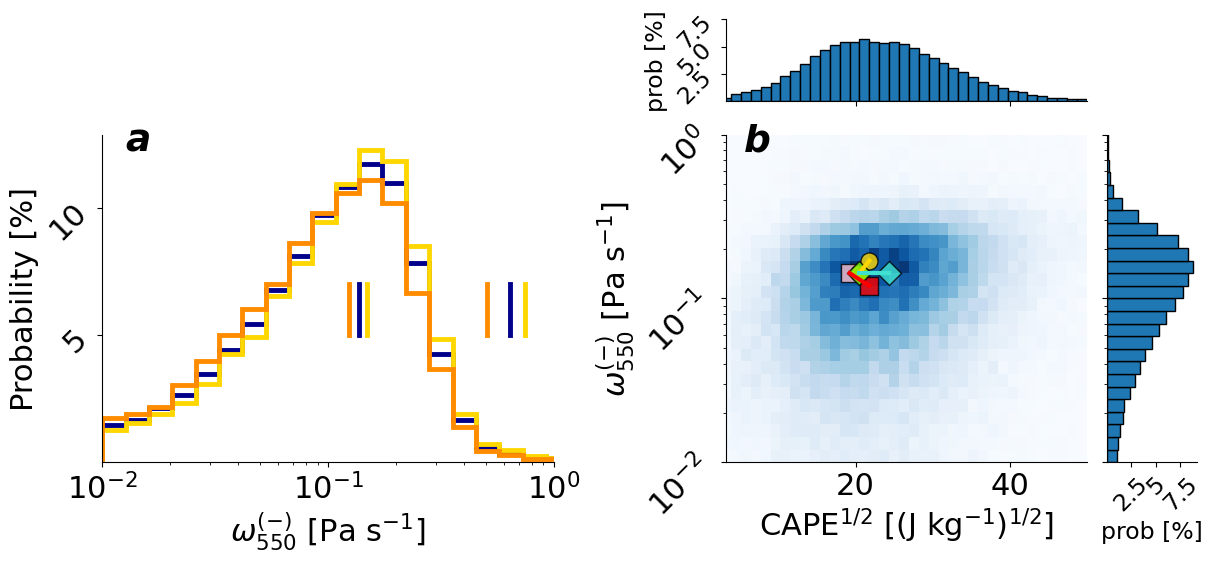

In [66]:
fig = plt.figure( figsize=(12,5.5), constrained_layout=True )
font_size = 22
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})
gs = fig.add_gridspec( 2, 4, width_ratios=(4, 1, 4, 1), height_ratios=(1, 4), left=0.1, right=0.9, bottom=0.1, top=0.9,
                     wspace=0.05, hspace=0.05 )
ax = fig.add_subplot( gs[1,2] )
ax_histx = fig.add_subplot( gs[0,2], sharex=ax )
ax_histy = fig.add_subplot( gs[1,3], sharey=ax )

## main panel a
i = np.where( (~np.isnan(cape_ERAI_n)) & (~np.isnan(omega_ERAI_mid_n)) & (cape_ERAI_n > 10) )
scatter_hist( cape_ERAI_n[i]**0.5, omega_ERAI_mid_n[i], xbins1, ybins1, ax, ax_histx, ax_histy )
#ax.set_xticks( [20, 40, 60, 80] )
ax_histx.set_ylabel( 'prob [%]', fontsize=font_size-5 )
ax_histx.set_yticks( [2.5, 5, 7.5], rotation=45 )
ax_histy.set_xlabel( 'prob [%]', fontsize=font_size-5 )
ax_histy.set_xticks( [2.5, 5, 7.5] )
ax_histy.set_xticklabels( [2.5, 5, 7.5], rotation=45 )
ax.set_ylabel( r'$\omega_{550}^{(-)}$ [Pa s$^{-1}$]' )
ax.set_xlabel( r'CAPE$^{1/2}$ [(J kg$^{-1})^{1/2}$]' )
ax.set_yscale('log')
ax.set_ylim([10**(-2),1])
ax.set_xlim([np.sqrt(10), 50])
ax.text( 0.05, 0.95, 'b', style='italic', weight='bold', fontsize=font_size+5, transform=ax.transAxes )
##

# Where is the center of mass of the joint distribution for young/old/big/small systems? 
# (The cells below must be run for this.)
h_list = [ h1, h2 , h3, h4, h5, h6 ]
farbe = [ 'red', 'pink', 'gold', 'darkorange', 'turquoise', 'lawngreen' ]
forme = [ 's', 's', 'o', 'o', 'D', 'D' ]
#grose = [ 200, 200, 200, 200, 200, 200 ]
for i, histo, f, s in zip( np.arange(6), h_list, farbe, forme ):
    l, m = unravel_index( histo[0].argmax(), histo[0].shape )
    ax.scatter( xbins1[l], ybins1[m], marker=s, color=f, s=150, zorder=5, edgecolor='k', alpha=0.8 )
    if i%2 == 0:
        ll, mm = unravel_index( h_csfpmax[i+1][0].argmax(), h_csfpmax[i+1][0].shape )
        ax.plot( [xbins1[l], xbins1[ll]], [ybins1[m], ybins1[mm]], lw=3, color=f, zorder=10 )

ax2 = fig.add_subplot( gs[1,0:2] )
farbe = [ 'darkblue', 'gold', 'darkorange', 'turquoise', 'lawngreen', 'pink', 'red' ]
lw = 3.5
for j in np.arange(3):
    print(j)
    i = np.argwhere( ~np.isnan(ascent550_list[j]) )
    wgts = np.ones_like( ascent550_list[j][i[:,0]] ) / float(len( ascent550_list[j][i[:,0]] ))*100 
    h, edges = np.histogram( ascent550_list[j][i[:,0]], weights=wgts, bins=np.logspace(-2,1,30) )
    ax2.stairs( h, edges, edgecolor=farbe[j], lw=lw )#, label=lbls[j][k] )
    m = np.nanmean(ascent550_list[j][i[:,0]])
    ax2.plot( [m, m], [5, 7], color=farbe[j], lw=lw )
    m = np.nanpercentile(ascent550_list[j][i[:,0]], 99)
    print(m)
    ax2.plot( [m, m], [5, 7], color=farbe[j], lw=lw )
        
ax2.set_xscale( 'log' )
ax2.set_xlim( [10**(-2),1] )
ax2.set_xlabel( r'$\omega_{550}^{(-)}$ [Pa s$^{-1}$]' )
ax2.set_ylabel( 'Probability [%]' )
ax2.set_yticks([5, 10])
ax2.text( 0.05, 0.95, 'a', style='italic', weight='bold', fontsize=font_size+5, transform=ax2.transAxes )

for a in ax, ax_histx, ax_histy, ax2:
    a.spines['top'].set_visible( False )
    a.spines['right'].set_visible( False )
    for t in a.get_yticklabels():
        t.set_rotation(45)

plt.tight_layout()
#

fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/cape-ascent-joint-ERAI.pdf', bbox_inches='tight' )
plt.show()